## Imports

In [3]:
import os
import sys
import pandas as pd
import seaborn as sns

from typing import List, Union
from pydantic import validate_arguments

# Importing functions from src/data
parent_dir = os.path.abspath(os.path.join('..'))
module_path = parent_dir + "/src/data"

if module_path not in sys.path:
    sys.path.append(module_path)

import database as db
import api
import pickle_helpers as pkle
import constants as cnt

## Table of Contents

1. [Data Collection](#data-collection)
2. [Data Validation](#data-validation)
3. [Preprocessing](#preprocessing)

### Data Collection

The average price is collected from an API and stored in a postgresql database. In order to retrieve the data in order to begin any analysis we make a query to the database which is handled by the market_data function below.

The data recieved is in the format of a list of 3-tuples containing a unique id, time and price at that time.

In [20]:
@validate_arguments
def market_data(item_name: str, region_id: str | int = "0", order_type: str = "buy", stat: str = "weightedAverage") -> List:
    """ Makes a query to the postgresql database market_data based on the parameters specified.

    Args:
        item_name (str): Provide the name of the raw material,
        
        region_id (str, int): Select region id of the market data. defaults to "0".
        
            - There are 7 Regions
                - Global - 0
                - Jita - 30000142
                - Perimeter - 30000144
                - Jita 4-4 CNAP - 60003760
                - Amarr VIII - 60008494
                - Dodixie - 60011866
                - Rens - 60004588
                - Hek - 60005686
                
        order_type (str, optional): Either 'buy' or 'sell' orders. Defaults to "buy".
        
        stat(str): Select the summary statistic to return

            - Valid args for stat:
                - weightedAverage
                - max
                - min
                - stddev
                - median
                - volume
                - orderCount
                - percentile

    Returns:
        List: Contains a list of tuples containing id, time, and data from market_data
    """
    # Validating and reformating arguments into proper format
    order_type = order_type.lower()
    
    itemid = api.get_item_id(item_name)
    
    # Postgresql query unpacking JSON data field
    command = (
        f"""
        SELECT id, time, data -> '{itemid}' -> '{order_type}'
        FROM market_data
        WHERE region_id = {region_id}
        """
        )
    
    results = db.postgresql_command(command, results=True)
    
    return results
    

In [41]:
# TODO: Improve function to follow dry principles
def create_item_dataframe(raw_material_name: str, region_id: str | int = "0"):
    # Historical average buy order stats for raw_material_name
    market_stats = market_data(raw_material_name, region_id=region_id)
    silicon_market_stats = [i[2] for i in market_stats]
    times = [i[1] for i in market_stats]

    # Joining together dataframes
    df = pd.DataFrame(data=silicon_market_stats)
    df.rename(columns=lambda x: "buy_" + x, inplace=True)
    
    df1 = pd.DataFrame(data=times, columns=["time"])

    df = pd.concat([df1, df], axis=1)
    
    market_stats = market_data(raw_material_name, region_id=region_id, order_type="sell")
    silicon_market_stats = [i[2] for i in market_stats]
    times = [i[1] for i in market_stats]

    # Joining together dataframes
    df_sell = pd.DataFrame(data=silicon_market_stats)
    df_sell.rename(columns=lambda x: "sell_" + x, inplace=True)
    
    df_times = pd.DataFrame(data=times, columns=["time"])
    #df_sell = pd.concat([df_times, df_sell])
    
    df = pd.concat([df, df_sell], axis=1)
    
    return df

def create_item_plot(raw_material_name: str):
    pass

In [42]:
#market_data("Silicon", "0", order_type="sell")
create_item_dataframe("Silicon", "0")

Command executed successfully
Command executed successfully


,time,buy_weightedAverage,buy_max,buy_min,buy_stddev,buy_median,buy_volume,buy_orderCount,buy_percentile,sell_weightedAverage,sell_max,sell_min,sell_stddev,sell_median,sell_volume,sell_orderCount,sell_percentile
0,2022-05-31 20:00:39.045802,326.975600297,600.0,0.01,170.722074106,400.0,19685167.0,77,564.817237812,641.592849884,1894.0,266.1,179.811435278,598.55,9885154.0,82,353.266681733
1,2022-05-23 17:43:39.109944,330.190015147,600.0,0.01,168.36763119,366.2,18434738.0,75,547.640245172,624.754950951,5916.0,200.0,636.53045546,633.9,7064926.0,77,333.442697347
2,2022-05-23 17:51:28.265570,330.185014122,600.0,0.01,168.36763119,366.2,18433098.0,75,547.642704335,624.754950951,5916.0,200.0,636.53045546,633.9,7064926.0,77,333.442697347
3,2022-05-23 17:53:37.343203,330.185014122,600.0,0.01,168.36763119,366.2,18433098.0,75,547.642704335,624.754950951,5916.0,200.0,636.53045546,633.9,7064926.0,77,333.442697347
4,2022-05-23 17:56:09.378611,330.185014122,600.0,0.01,168.36763119,366.2,18433098.0,75,547.642704335,624.754950951,5916.0,200.0,636.53045546,633.9,7064926.0,77,333.442697347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2022-05-31 19:00:39.984463,326.96722329,600.0,0.01,170.073222744,393.6,19684667.0,76,564.815063968,641.418572003,1894.0,266.1,179.811435278,598.55,9914644.0,82,353.369992105
154,2022-05-31 21:00:38.991354,326.945757153,600.0,0.01,170.722074106,400.0,19681685.0,77,564.818373122,641.597592154,1894.0,266.1,179.811435278,598.55,9884354.0,82,353.263870557
155,2022-05-31 22:00:40.547459,326.877123451,600.0,0.01,170.722074106,400.0,19675893.0,77,564.810253908,641.597592154,1894.0,266.1,179.811435278,598.55,9884354.0,82,353.263870557
156,2022-05-31 23:00:39.361122,326.877123451,600.0,0.01,170.722074106,400.0,19675893.0,77,564.810253908,641.400835738,1894.0,266.1,179.811435278,598.55,9916028.0,82,353.374825485


In [33]:
# Historical average buy order stats for Silicon
market_stats = market_data("Silicon")
silicon_market_stats = [i[2] for i in market_stats]
times = [i[1] for i in market_stats]

# Joining together dataframes
df = pd.DataFrame(data=silicon_market_stats)
df1 = pd.DataFrame(data=times, columns=["time"])

df_buy = pd.concat([df1, df], axis=1)
df_buy

Command executed successfully


,time,weightedAverage,max,min,stddev,median,volume,orderCount,percentile
0,2022-05-31 20:00:39.045802,326.975600297,600.0,0.01,170.722074106,400.0,19685167.0,77,564.817237812
1,2022-05-23 17:43:39.109944,330.190015147,600.0,0.01,168.36763119,366.2,18434738.0,75,547.640245172
2,2022-05-23 17:51:28.265570,330.185014122,600.0,0.01,168.36763119,366.2,18433098.0,75,547.642704335
3,2022-05-23 17:53:37.343203,330.185014122,600.0,0.01,168.36763119,366.2,18433098.0,75,547.642704335
4,2022-05-23 17:56:09.378611,330.185014122,600.0,0.01,168.36763119,366.2,18433098.0,75,547.642704335
...,...,...,...,...,...,...,...,...,...
153,2022-05-31 19:00:39.984463,326.96722329,600.0,0.01,170.073222744,393.6,19684667.0,76,564.815063968
154,2022-05-31 21:00:38.991354,326.945757153,600.0,0.01,170.722074106,400.0,19681685.0,77,564.818373122
155,2022-05-31 22:00:40.547459,326.877123451,600.0,0.01,170.722074106,400.0,19675893.0,77,564.810253908
156,2022-05-31 23:00:39.361122,326.877123451,600.0,0.01,170.722074106,400.0,19675893.0,77,564.810253908


In [159]:
# Fixing datatype for all the columns except the time column
for i in df_buy.iloc[:,1:].columns:
    df_buy[i] = pd.to_numeric(df_buy[i])
    
df_buy[['time', 'median', 'weightedAverage']]

,time,median,weightedAverage
0,2022-05-23 17:43:39.109944,366.2,330.190015
1,2022-05-23 17:51:28.265570,366.2,330.185014
2,2022-05-23 17:53:37.343203,366.2,330.185014
3,2022-05-23 17:56:09.378611,366.2,330.185014
4,2022-05-23 18:00:36.550194,366.2,330.185014
...,...,...,...
133,2022-05-31 00:00:40.991810,400.0,327.639856
134,2022-05-31 01:00:40.873256,400.0,327.639856
135,2022-05-31 02:00:38.231644,400.0,327.639856
136,2022-05-31 03:00:41.165245,400.0,327.639856


In [160]:

pd.melt(df_buy[['time', 'median', 'weightedAverage']], ["time"])

,time,variable,value
0,2022-05-23 17:43:39.109944,median,366.200000
1,2022-05-23 17:51:28.265570,median,366.200000
2,2022-05-23 17:53:37.343203,median,366.200000
3,2022-05-23 17:56:09.378611,median,366.200000
4,2022-05-23 18:00:36.550194,median,366.200000
...,...,...,...
271,2022-05-31 00:00:40.991810,weightedAverage,327.639856
272,2022-05-31 01:00:40.873256,weightedAverage,327.639856
273,2022-05-31 02:00:38.231644,weightedAverage,327.639856
274,2022-05-31 03:00:41.165245,weightedAverage,327.639856


[Text(0.5, 1.0, 'The Price of Silicon'), Text(0, 0.5, 'Price (ISK)')]

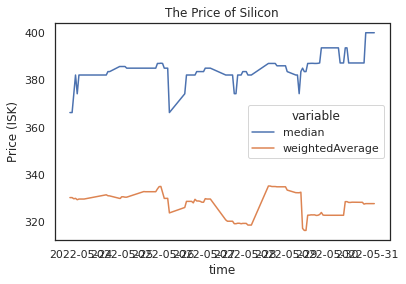

In [161]:
# Plot
sns.set_theme(style="white")
plt = sns.lineplot(data=pd.melt(df_buy[['time', 'median', 'weightedAverage']], ["time"]), x='time', y='value', hue='variable')
plt.set(title="The Price of Silicon", ylabel="Price (ISK)")



In [162]:
# Create function that will generate plots given the name of a raw material